# Exercise 2

## Imports

In [1]:
import os.path
import random
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StringType, ArrayType, IntegerType, StructType, StructField
from itertools import combinations, chain
from functools import partial
from typing import Iterable, Any, List, Callable

## Parameters

The values for parameters $b$ and $r$ chosen, according to the requirements, were:
- $b = 13$
- $r = 11$

The values were hand-picked by visually analyzing the plot for the probability of two documents sharing a bucket depending on their similarity, as $b$ and $r$ changed.

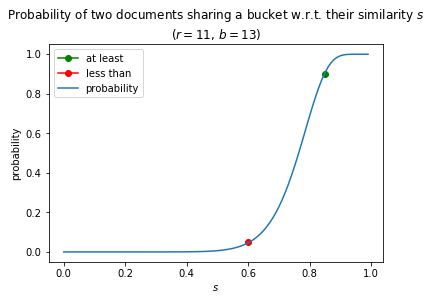

In [2]:
N = 100

r = 11
b = 13

point_below = (0.85, 0.9)
point_above = (0.6, 0.05)

prob = lambda s, r, b: 1 - (1 - s**r)**b

try:
    import matplotlib.pyplot as plt

    ss = [i/N for i in range(N)]

    plt.plot(*point_below, color='g', marker='o')
    plt.plot(*point_above, color='r', marker='o')
    plt.plot(ss, [prob(s, r, b) for s in ss])

    plt.title(f'Probability of two documents sharing a bucket w.r.t. their similarity $s$\n($r={r}$, $b={b}$)')
    plt.legend(['at least', 'less than', 'probability'])
    plt.xlabel('$s$')
    plt.ylabel('probability')

    plt.show()

except ImportError:
    print('Could not plot, since the \'matplotlib\' module is not present.')

assert prob(point_below[0], r, b) >= point_below[1], 'Pairs with a similarity of 85%% should have at least 90%% probability of sharing a bucket!'
assert prob(point_above[0], r, b) <  point_above[1], 'Pairs with a similarity of 60%% should have less than 5%% probability of sharing a bucket!'

In [2]:
# Shingle size
k = 9

# Number of bands
b = 13

# Number of rows per band
r = 11

# Min-hash: number of hash functions
num_functions = b*r

# Seed for the random number generator
seed = 123

# Similarity threshold
similarity_threshold = 0.85

# Sample of the dataset to use
sample_fraction = 0.01

# Number of explicit partitions
num_partitions = 8

In [3]:
random.seed(seed)

## Spark Initialization

In [4]:
spark = SparkSession.builder \
    .appName('LSH') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

23/03/21 10:12:02 WARN Utils: Your hostname, martinho-SATELLITE-L50-B resolves to a loopback address: 127.0.1.1; using 192.168.1.66 instead (on interface enp8s0)
23/03/21 10:12:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/21 10:12:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Prepare the Data

In [5]:
# TODO: Configure partitions for speedup?
df = spark.read \
    .json('./data/covid_news_small.json.bz2') \
    .sample(fraction=0.01, seed=seed, withReplacement=False) \
    .repartition(num_partitions)

## Pipeline

### Generate shingles

In [6]:
# TODO: ignore punctuation? use different shingling strategy? (see 'Further fun' slide, which is the last, of 3b)
@F.udf(returnType=ArrayType(IntegerType(), False))
def generate_shingles(text: str):
    shingles = (text[idx:idx+k] for idx in range(len(text) - k + 1))
    # Get last 32 bits in order to have 4-byte integers (Python allows arbitrarily large integers)
    to_integer = lambda s: hash(s) & ((1 << 32) - 1)
    return list(set(to_integer(shingle_str) for shingle_str in shingles))

In [7]:
df_shingles = df \
    .drop('url') \
    .filter(F.length('text') >= k) \
    .repartition(num_partitions) \
    .withColumn('shingles', generate_shingles('text')) \
    .drop('text')

### Min-hash

In [8]:
# Assumes the values to hash are 4-byte integers
def generate_universal_hash_family(K: int) -> List[Callable[[int], int]]:
    N = 1 << 32
    p = 2305843009213693951

    parameters = set()
    while (len(parameters) < K):
        parameters |= {(random.randint(1, N), random.randint(0, N)) for _ in range(K - len(parameters))}
    
    return [(a, b, p, N) for a, b in parameters]

In [9]:
hash_family = generate_universal_hash_family(num_functions)
broadcasted_hash_family = spark.sparkContext.broadcast(hash_family)

In [11]:
@F.udf(returnType=ArrayType(IntegerType(), False))
def calculate_min_hash(shingles: List[int]):
    return [min(((a * shingle + b) % p) % N for shingle in shingles) for (a, b, p, N) in broadcasted_hash_family.value]

In [12]:
df_minhash = df_shingles.withColumn('min_hash', calculate_min_hash('shingles')).drop('shingles')

#### Benchmark

In [11]:
import time

In [14]:
t = time.time()
hash_col_names = [f'hashed_{i}' for i in range(num_functions)]

data = df_shingles \
    .withColumn('shingles', F.explode('shingles')) \
    .withColumnRenamed('shingles', 'shingle') \
    .select('tweet_id', *( (((a * F.col('shingle') + b) % p) % N).alias(name) for (a, b, p, N), name in zip(hash_family, hash_col_names) )) \
    .groupby('tweet_id') \
    .min(*hash_col_names) \
    .withColumn('min_hash', F.array(*(f'min({name})' for name in hash_col_names))) \
    .collect()

print('Execution time:', time.time() - t)

KeyboardInterrupt: 

In [15]:
# t = time.time()
# N = 1 << 32
# p = 2305843009213693951

# data2 = df_shingles \
#     .withColumn('shingles', F.explode('shingles')) \
#     .withColumnRenamed('shingles', 'shingle') \
#     .withColumn('hash_params', F.explode(F.array(*(F.struct(F.lit(a).alias('a'), F.lit(b).alias('b')) for a, b, p, N in hash_family)))) \
#     .withColumn('shingle', ((F.col('hash_params').a * F.col('shingle') + F.col('hash_params').b) % p) % N) \
#     .groupby('tweet_id', 'hash_params') \
#     .min('shingle') \
#     .collect()

# print('Execution time:', time.time() - t)

Execution time: 1232.6093702316284


In [14]:
# t = time.time()

# data3 = df_minhash.collect()

# print('Execution time:', time.time() - t)

KeyboardInterrupt: 

In [ ]:
fname_minhash = f'minhash_{r}_{b}'
if not os.path.exists(fname_minhash):
    df_minhash.write.mode('overwrite').parquet(path=fname_minhash, compression='gzip')

df_minhash = spark.read.parquet(fname_minhash)

### LSH

In [ ]:
@F.udf(returnType=ArrayType(ArrayType(IntegerType(), False), False))
def generate_even_slices(minhashes: List[int]):
    return [minhashes[i:i+b] for i in range(0, num_functions, b)]

In [ ]:
df_bands = df_minhash \
    .withColumn('min_hash_slices', generate_even_slices('min_hash')) \
    .select('tweet_id', *(F.hash(F.col('min_hash_slices')[band]).alias(f'band_{band}') for band in range(b))) 

In [ ]:
@F.udf(returnType=ArrayType(ArrayType(StringType(), False), False))
def combine_pairs(elems: Iterable[Any]):
    return list(combinations(elems, 2))

In [ ]:
df_bands_lst = [
    df_bands
        .select('tweet_id', f'band_{band}')
        .groupby(f'band_{band}')
        .agg(F.collect_list('tweet_id'))
        .withColumnRenamed('collect_list(tweet_id)', 'candidates')
        .withColumn('candidates', F.array_sort('candidates'))
        .select(F.explode(combine_pairs('candidates')).alias('candidate_pair'))
    for band in range(b)
]

In [ ]:
df_candidate_pairs = spark.createDataFrame([], schema=StructType([StructField(name='candidate_pair', dataType=ArrayType(StringType(), False), nullable=False)]))

for d in df_bands_lst:
    df_candidate_pairs = df_candidate_pairs.union(d)

df_candidate_pairs = df_candidate_pairs.distinct()

Remove false positives.

In [ ]:
df_candidate_pairs_fpless = df_candidate_pairs \
    .join(df_minhash, df_minhash['tweet_id'] == F.col('candidate_pair')[0]) \
    .withColumnRenamed('min_hash', 'min_hash_first') \
    .drop('tweet_id') \
    .join(df_minhash, df_minhash['tweet_id'] == F.col('candidate_pair')[1]) \
    .withColumnRenamed('min_hash', 'min_hash_second') \
    .drop('tweet_id') \
    .withColumn('similarity', F.size(F.array_intersect('min_hash_first', 'min_hash_second')) / F.size(F.array_union('min_hash_first', 'min_hash_second'))) \
    .filter(F.col('similarity') >= similarity_threshold)

Save results.

In [ ]:
fname_candidate_pairs_fpless = f'candidate_pairs_{r}_{b}'
if not os.path.exists(fname_candidate_pairs_fpless):
    df_candidate_pairs_fpless.write.mode('overwrite').parquet(path=fname_candidate_pairs_fpless, compression='gzip')

df_candidate_pairs_fpless = spark.read.parquet(fname_candidate_pairs_fpless)

Get similar articles.

In [ ]:
def get_similar_articles(tweet_id: str) -> List[str]:
    rows = df_candidate_pairs_fpless \
        .filter(F.array_contains('candidate_pair', tweet_id)) \
        .select(F.array_remove('candidate_pair', tweet_id).alias('sole_candidate')) \
        .select(F.col('sole_candidate')[0].alias('similar_article')) \
        .collect()

    return [row.similar_article for row in rows]

## Analysis of false positives/negatives

Load sample of the data.

In [ ]:
...

Getting the false positive percentage.

In [ ]:
print('Percentage of false positives:', (df_candidate_pairs.count() - df_candidate_pairs_fpless.count()) / df_minhash.count())

Getting the false negative percentage.

In [7]:
df_tweets_with_candidates = df_candidate_pairs.select(F.explode('candidate_pair').alias('tweet_with_candidates')).distinct()

NameError: name 'df_candidate_pairs' is not defined

In [ ]:
df_minhash